# Drone Crashmas

In [1]:
import networkx as nx
from pymongo import MongoClient
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
from urllib.parse import urlsplit
from urllib.parse import urlparse
import requests
import http.client
import matplotlib.pyplot as plt
import datetime as dt
import statistics

In [2]:
client = MongoClient('mongodb://localhost:27017')
db = client["twitterdb"]
collection = db.droneCrashmas2019

Twitter data is stored as strings in MongoDB. In order to search chronologically against the `created_at` date, we need to convert it to a datetime before querying against it.

In [3]:
projection = {
        #convert created_at to date
        '$project': {
            '_id': 0, 
            'id': 1, 
            'created_at': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            }, 
            'user': 1, 
            'entities': 1, 
            'lang': 1, 
            'text': 1, 
            'retweeted_status': 1
        }
    }

match = {
        '$match': {
            'created_at': {
                '$lte': dt.datetime(2020, 1, 1, 0, 0, 0, tzinfo=dt.timezone.utc)
            }
        }
    }

In [4]:
cursor = collection.aggregate([projection, match])
df =  pd.DataFrame(list(cursor))

Localize to the `US/Eastern` timezone and constrain dates further:

In [5]:
df['created_at'] = df['created_at'].dt.tz_localize('UTC')
df['created_at'] = df['created_at'].dt.tz_convert('US/Eastern')
df = df[(df['created_at'] >= '2019-12-21 00:00:00') & (df['created_at'] <= '2019-12-31 23:59:59')]
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df.shape

(429445, 9)

We're looking for toy drones and misshapes related to christmas, so we want to eliminate tweets referring to airstrikes:

In [6]:
df['text'] = df['text'].str.lower()
df = df[~df['text'].str.contains('iraq|afghanistan|libya|syria|airstrike|soleimani|suleimani|qaeda|terrorist', na=False)]

For the sake of simplicity, I'm limiting this to english for now:

In [7]:
df['lang'] = df['lang'].replace('en-gb', 'en-GB')
df['lang'] = df['lang'].replace('en-GB', 'en')
df_en = df.loc[df['lang'] == 'en']

Extract user names so I can exclude certain users:

In [8]:
user_flat = json_normalize(df['user'])
df['screen_name'] = user_flat['screen_name']
user_flat.drop(user_flat.index, inplace=True)

In [9]:
crashmas = pd.DataFrame()
crashmas = df[df['text'].str.contains('dad|brother|hair|crash|dog|cat|roof|mom|mother|grandmother|grandma|sister|grandfather|grandpa|tree|lake|pond|ocean|lost|crashed|broken|broke|vanished|uncle', na=True)].reset_index()
crashmas = crashmas.loc[crashmas['lang'] == 'en']
crashmas = crashmas[~crashmas['screen_name'].str.contains('mountainherder|faineg', na=False)]
crashmas.shape

(18684, 11)

C:\Users\scarn\Anaconda3\envs\brasil\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)
C:\Users\scarn\Anaconda3\envs\brasil\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


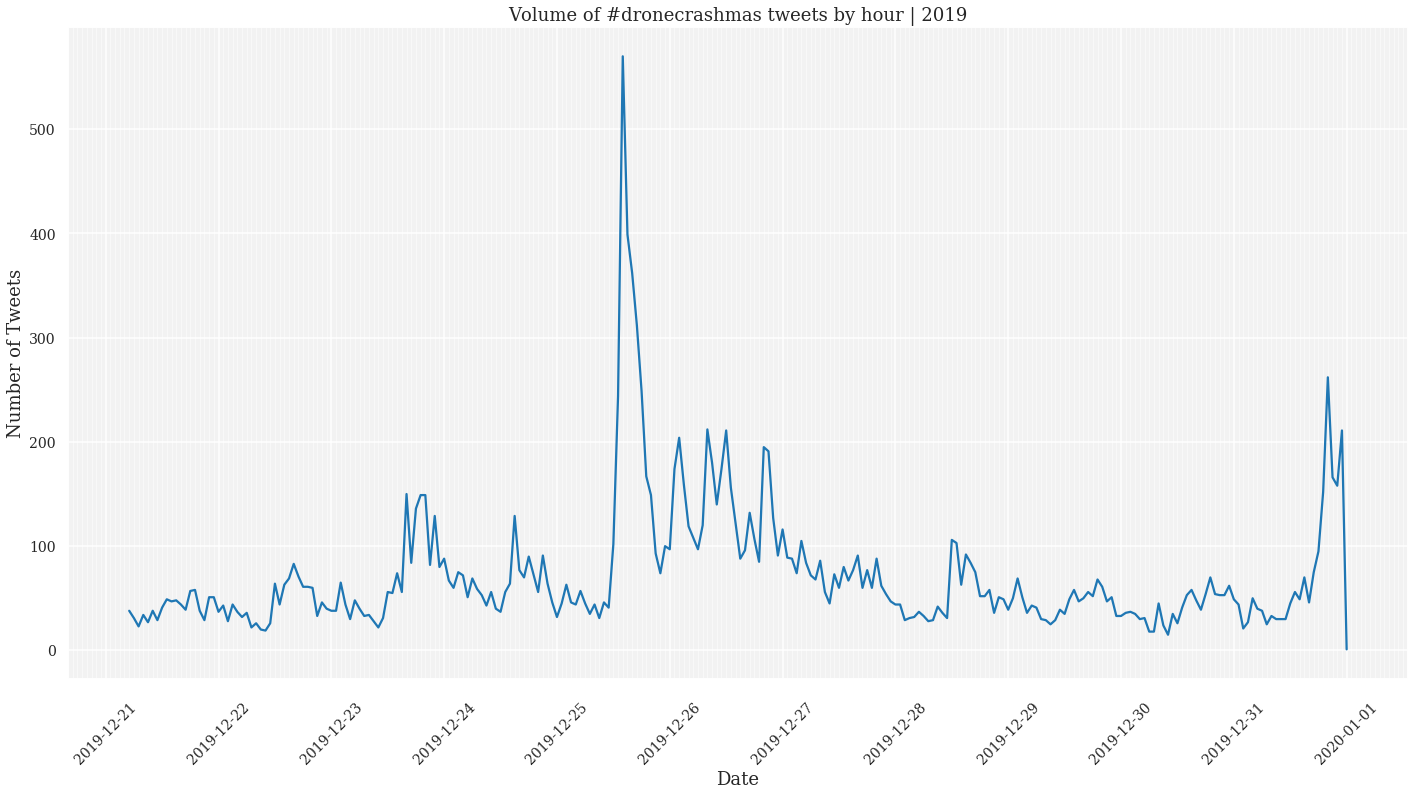

In [10]:
crashmas_2 = crashmas.groupby(crashmas['created_at'].rename('Date')).size().reset_index(name='Number of Tweets')
crashmas_2 = crashmas_2.set_index(['Date'])
#crashmas_2.index = pd.to_datetime(crashmas_2.index, unit='s')
crashmas_resampled = crashmas_2.resample('H').sum().reset_index()

import matplotlib.dates as mdates
sns.set_context("talk")
sns.set_style("darkgrid", {'axes.facecolor':'.95'})
plt.figure(figsize=(24, 12))
plt.rcParams['font.family'] = "serif"
plt.xticks(rotation=45)
lp = sns.lineplot(data=crashmas_resampled, x="Date", y="Number of Tweets", markers=True)
lp.xaxis.set_major_locator(mdates.DayLocator())
lp.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
lp.xaxis.set_minor_locator(mdates.HourLocator())
#lp.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
lp.tick_params(axis="x", which="major", pad=12)
lp.grid(b=True, which='minor', color='w', linewidth=0.5)
for label in (lp.get_xticklabels() + lp.get_yticklabels()):
    label.set_fontsize(14)
for label in (lp.get_xminorticklabels()):
    label.set_fontsize(8)
    label.set_rotation(45)
g1 = lp.set_title('Volume of #dronecrashmas tweets by hour | 2019').get_figure()
g1.savefig("Tweets_Hour_Dads.png")

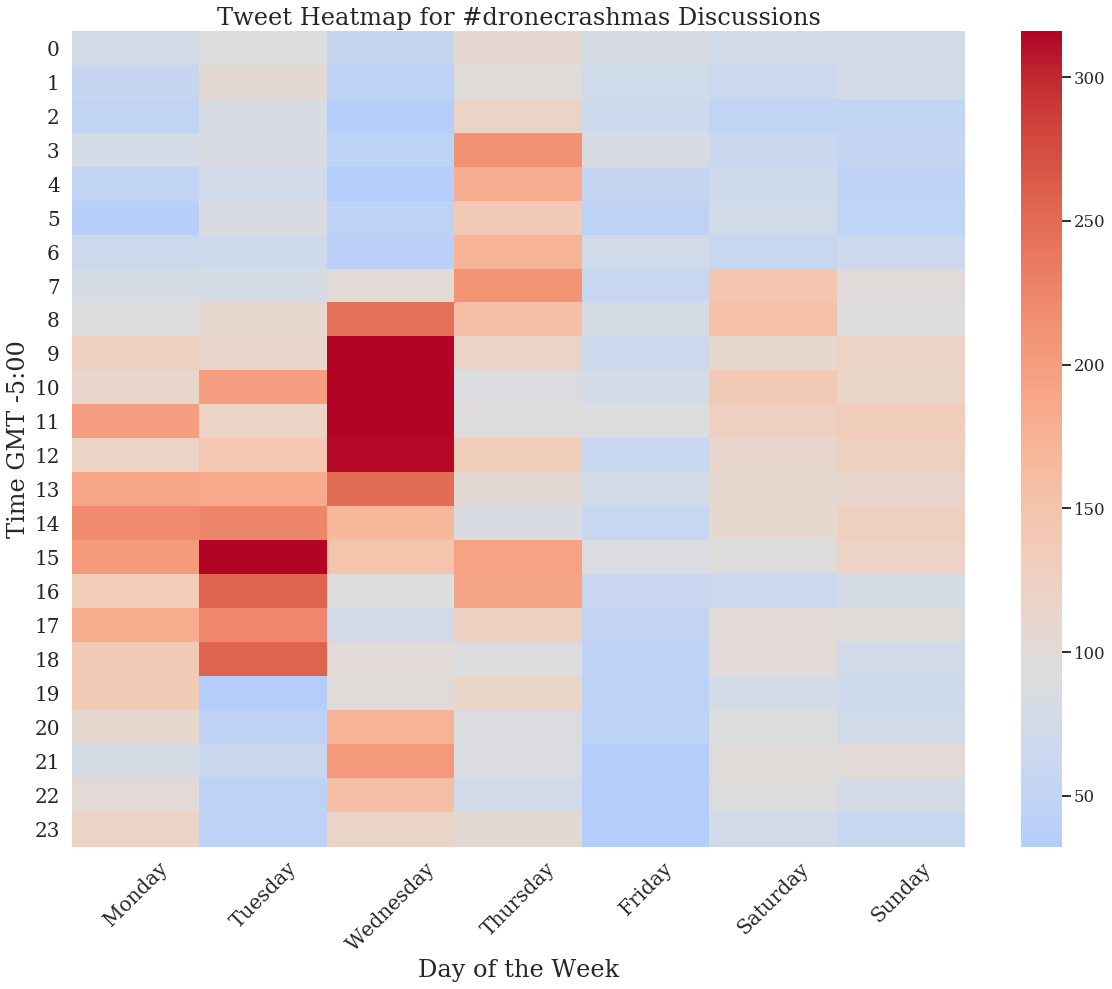

In [11]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
tweets_timeline = crashmas.groupby(by=['hour', 'day_of_week'])['created_at'].count()

midpoint = statistics.median(tweets_timeline)

plt.figure(figsize=(20, 15))
plt.rcParams['font.family'] = "serif"
plt.title('Tweet Heatmap for #dronecrashmas Discussions', fontsize=24)

ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='coolwarm',
                  robust=True,
                  center=midpoint,
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Day of the Week', fontsize=24)
plt.ylabel('Time GMT -5:00', fontsize=24)
ax.get_figure().savefig('heatmap_drones.png')

## URLs, Users, and Hashtags
This code no longer works correctly. Whether it is user error or a change in how twitter nests arrays, I need further time to fix it. It is supposed to take MongoDB documents containing nested data and flatten them, using json_normalize

### URLs

In [ ]:
#tweets_flat = json_normalize(df['entities'])
entities_data = json_normalize(df['entities'], record_path='urls', meta=['hashtags', 'user_mentions'], errors='ignore')
entities_data['protocol'],entities_data['domain'],entities_data['path'],entities_data['query'],entities_data['fragment'] = zip(*[urlsplit(x) for x in entities_data['expanded_url']])
df['domain'] = entities_data['domain']
df['url'] = entities_data['expanded_url']
entities_data.drop(entities_data.index, inplace=True)
df.head()

In [ ]:
parsed_urls = pd.DataFrame()
parsed_urls = df['domain'].reset_index(name='url')
unique = parsed_urls.groupby('url')['index'].nunique()
unique.nlargest(25)

In [ ]:
url = pd.DataFrame()
url = df['url'].reset_index()
url = url.groupby('url')['index'].nunique()
url_list = url.nlargest(50).reset_index()
url_list.to_csv('top50URLs.csv', sep='\t')

### User Names

In [ ]:
user_count = df['screen_name'].reset_index(name='Screen Name')
user_count = user_count.groupby('Screen Name')['index'].nunique()
user_count.nlargest(25)

### Hashtags

In [37]:
hashtag_data = json_normalize(df['entities'], record_path='hashtags', meta=['user_mentions', 'urls'], errors='ignore')
df['hashtags'] = hashtag_data['text']
hashtag_data.drop(hashtag_data.index, inplace=True)

In [ ]:
hashtag_data = json_normalize(df['entities'], record_path='hashtags', meta=['user_mentions', 'urls'], errors='ignore')
hashtags = pd.DataFrame()
hashtags = hashtag_data['text'].reset_index(name='hashtags')
utags = hashtags.groupby('hashtags')['index'].nunique()
utags.nlargest(25)

## Text Analysis

In [39]:
from textblob import TextBlob
from textblob import Word
from dask import dataframe as dd
import pyarrow.parquet as pq
from multiprocessing import cpu_count

nCores =  cpu_count()

In [65]:
crashmas['text_analysis'] = crashmas['text']

In [67]:
#lowercase
crashmas_text = crashmas_text.apply(lambda x: " ".join(x.lower() for x in x.split()))

In [15]:
# Remove errant hashtags, usernames, punctuation and shortlinks
crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('#')))
crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))
crashmas['text_analysis'] = crashmas['text_analysis'].str.replace('[^\w\s]','')
crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('httpstco')))

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#remove most frequently used words
freq = pd.Series(' '.join(crashmas['text_analysis']).split()).value_counts()[:1]
freq = list(freq.index)
crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [56]:
#freq = pd.Series(' '.join(crashmas['text_analysis']).split()).value_counts()[-1000:]
#freq

ye           1
maulers      1
worthless    1
feat         1
jk           1
            ..
ep7          1
tops         1
ellems       1
skill        1
moved        1
Length: 1000, dtype: int64

In [17]:
#Spelling Correction (go get a coffee)

ddata = dd.from_pandas(crashmas['text_analysis'],npartitions=4*cpu_count())\
   .map_partitions(lambda df : df.apply(lambda x : str(TextBlob(x).correct())))\
   .compute(scheduler="processes")

#crashmas['text_analysis'] = crashmas['text_analysis'].apply(lambda x: str(TextBlob(x).correct())

In [19]:
TextBlob(ddata[1]).words

WordList(['conversation', 'impressive', 'bit', 'already', 'asking', 'camera', 'located', 'pitch'])

In [20]:
ddata = ddata.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
ddata.head()

1    conversation impressive bit already asking cam...
2    hard shell carrying backpack bag case waterpro...
4     drone clash water getting stunning view lake bed
5    maybe season feeling like time drone giveaway ...
6    conversation impressive bit already asking cam...
Name: text_analysis, dtype: object

In [72]:
crashmas_text = pd.DataFrame(ddata)

In [46]:
crashmas_text.to_parquet("crashmas_text.pq", engine="pyarrow") # Doesn't work.
#crashmas_text.to_csv("crashmas_text.csv")


In [106]:
crashmas_text.reset_index()
crashmas_text.head()

,text_analysis
1,conversation impressive bit already asking cam...
2,hard shell carrying backpack bag case waterpro...
4,drone clash water getting stunning view lake bed
5,maybe season feeling like time drone giveaway ...
6,conversation impressive bit already asking cam...


In [107]:
tf1 = (crashmas_text['text_analysis'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words', 'tf']

for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(crashmas_text.shape[0]/(len(crashmas_text[crashmas_text['text_analysis'].str.contains(word)])))

tf1

tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,case,1,4.729477,4.729477
1,magic,1,3.375518,3.375518
2,natural,1,6.945051,6.945051
3,digital,1,6.309062,6.309062
4,pro,1,2.338770,2.338770
5,carrying,1,5.923400,5.923400
6,may,1,3.370835,3.370835
7,waterproof,1,4.908169,4.908169
8,shell,1,6.539586,6.539586
9,backpack,1,7.002209,7.002209
